In [5]:
import os
print("Current directory:", os.getcwd())
os.listdir()


Current directory: C:\Users\Niarea


['.anaconda',
 '.cache',
 '.conda',
 '.condarc',
 '.continuum',
 '.expo',
 '.ipynb_checkpoints',
 '.ipython',
 '.jupyter',
 '.matplotlib',
 '.snowsql',
 '.ssh',
 'anaconda',
 'anaconda3',
 'AppData',
 'Application Data',
 'Contacts',
 'Cookies',
 'dataset_wind_blade',
 'Documents',
 'Downloads',
 'Favorites',
 'Links',
 'Local Settings',
 'LOOKOUT',
 'Music',
 'My Documents',
 'NetHood',
 'Niarea',
 'niarea_dm-app',
 'NTUSER.DAT',
 'ntuser.dat.LOG1',
 'ntuser.dat.LOG2',
 'NTUSER.DAT{448e2af6-5066-11f0-9fde-7cfa80f46217}.TM.blf',
 'NTUSER.DAT{448e2af6-5066-11f0-9fde-7cfa80f46217}.TMContainer00000000000000000001.regtrans-ms',
 'NTUSER.DAT{448e2af6-5066-11f0-9fde-7cfa80f46217}.TMContainer00000000000000000002.regtrans-ms',
 'ntuser.ini',
 'OneDrive',
 'PrintHood',
 'Recent',
 'Saved Games',
 'Searches',
 'SendTo',
 'Start Menu',
 'Templates',
 'Untitled.ipynb',
 'untitled.py',
 'Untitled1.ipynb',
 'Videos',
 'WTImages.zip',
 'WTSegmentation.ipynb']

In [6]:
import zipfile

zip_path = "WTImages.zip"                    
extract_path = "./dataset_wind_blade"       

os.makedirs(extract_path, exist_ok=True)

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("✅ Extracted to:", extract_path)


✅ Extracted to: ./dataset_wind_blade


In [8]:
for root, dirs, files in os.walk(extract_path):
    level = root.replace(extract_path, '').count(os.sep)
    indent = ' ' * 2 * level
    print(f"{indent}{os.path.basename(root)}/")
    subindent = ' ' * 2 * (level + 1)
    for f in files[:3]:
        print(f"{subindent}{f}")


dataset_wind_blade/
  Images/
    test-dev/
      Optical/
        DJI_20230403124230_0008/
          00000.jpg
          00001.jpg
          00002.jpg
        DJI_20230511123119_0048/
          00000.jpg
          00001.jpg
          00002.jpg
        Mavic1_DJI_0865/
          00000.jpg
          00001.jpg
          00002.jpg
        Mavic1_DJI_0873/
          00000.jpg
          00001.jpg
          00002.jpg
        Mavic1_DJI_0877/
          00000.jpg
          00001.jpg
          00002.jpg
        Mavic1_DJI_0883/
          00000.jpg
          00001.jpg
          00002.jpg
      Thermal/
        DJI_20230403124230_0008/
          00000.jpg
          00001.jpg
          00002.jpg
        DJI_20230511123119_0048/
          00000.jpg
          00001.jpg
          00002.jpg
        Mavic1_DJI_0865/
          00000.jpg
          00001.jpg
          00002.jpg
        Mavic1_DJI_0873/
          00000.jpg
          00001.jpg
          00002.jpg
        Mavic1_DJI_0877/
          00000.jpg

In [10]:
dataset_root = "./dataset_wind_blade/Images/trainval"


In [11]:
# ===============================
# AQUADA-Seg: Optical-Thermal Blade Segmentation (Image-based)
# ===============================

import os
import zipfile
from pathlib import Path
from typing import Optional, Tuple
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, models
from torch.utils.data import Dataset, DataLoader
from PIL import Image

# ----------- STEP 1: Extract uploaded dataset -----------

zip_path = "WTImages.zip"  # name of uploaded zip
extract_path = "./dataset_wind_blade"

if not os.path.exists(extract_path):
    os.makedirs(extract_path, exist_ok=True)
    with zipfile.ZipFile(zip_path, "r") as zip_ref:
        zip_ref.extractall(extract_path)
    print(f"✅ Extracted dataset to: {extract_path}")
else:
    print(f"✅ Dataset already extracted at: {extract_path}")


# ----------- STEP 2: Utility functions & losses -----------

class DiceLoss(nn.Module):
    def __init__(self, eps: float = 1e-6):
        super().__init__()
        self.eps = eps

    def forward(self, logits, targets):
        probs = torch.sigmoid(logits)
        targets = targets.float()
        num = 2 * (probs * targets).sum(dim=(1, 2, 3))
        den = (probs + targets).sum(dim=(1, 2, 3))
        dice = (num + self.eps) / (den + self.eps)
        return 1 - dice.mean()


bce_loss = nn.BCEWithLogitsLoss()


# ----------- STEP 3: Image Dataset -----------

class ImageDataset(Dataset):
    """
    Load paired Optical + Thermal images from subfolders.
    """
    def __init__(self, root: str, split="trainval", transform=None):
        self.root = Path(root)
        self.split = split
        self.transform = transform
        self.opt_dir = self.root / "Images" / split / "Optical"
        self.th_dir = self.root / "Images" / split / "Thermal"

        # Recursively grab all image files in subfolders
        self.opt_imgs = sorted([p for p in self.opt_dir.rglob("*") if p.suffix.lower() in [".png",".jpg",".jpeg"]])
        self.th_imgs = sorted([p for p in self.th_dir.rglob("*") if p.suffix.lower() in [".png",".jpg",".jpeg"]])
        assert len(self.opt_imgs) == len(self.th_imgs), "Mismatch Optical vs Thermal images"

    def __len__(self):
        return len(self.opt_imgs)

    def __getitem__(self, idx):
        opt_img = Image.open(self.opt_imgs[idx]).convert("RGB")
        th_img = Image.open(self.th_imgs[idx]).convert("RGB")
        if self.transform:
            opt_img = self.transform(opt_img)
            th_img = self.transform(th_img)
        return opt_img, th_img


def load_image(path: str, transform=None):
    img = Image.open(path).convert("RGB")
    return transform(img) if transform else transforms.ToTensor()(img)


# ----------- STEP 6: Run training demo -----------

DATA_ROOT = "./dataset_wind_blade"
device = "cuda" if torch.cuda.is_available() else "cpu"

# Create dataset
dataset = ImageDataset(DATA_ROOT, split="trainval")

# ---------- Quick check for pairing ----------
print("🔎 Checking optical and thermal image pairing...")
for i in range(10):  # check first 10 images
    opt_path = dataset.opt_imgs[i]
    th_path = dataset.th_imgs[i]
    print(f"Pair {i+1}:")
    print(f"  Optical: {opt_path.name}")
    print(f"  Thermal: {th_path.name}")
    opt_img = Image.open(opt_path).convert("RGB")
    th_img = Image.open(th_path).convert("RGB")
    print(f"  Shapes - Optical: {opt_img.size}, Thermal: {th_img.size}\n")




✅ Dataset already extracted at: ./dataset_wind_blade
🔎 Checking optical and thermal image pairing...
Pair 1:
  Optical: 00000.jpg
  Thermal: 00000.jpg
  Shapes - Optical: (853, 480), Thermal: (853, 480)

Pair 2:
  Optical: 00001.jpg
  Thermal: 00001.jpg
  Shapes - Optical: (853, 480), Thermal: (853, 480)

Pair 3:
  Optical: 00002.jpg
  Thermal: 00002.jpg
  Shapes - Optical: (853, 480), Thermal: (853, 480)

Pair 4:
  Optical: 00003.jpg
  Thermal: 00003.jpg
  Shapes - Optical: (853, 480), Thermal: (853, 480)

Pair 5:
  Optical: 00004.jpg
  Thermal: 00004.jpg
  Shapes - Optical: (853, 480), Thermal: (853, 480)

Pair 6:
  Optical: 00005.jpg
  Thermal: 00005.jpg
  Shapes - Optical: (853, 480), Thermal: (853, 480)

Pair 7:
  Optical: 00006.jpg
  Thermal: 00006.jpg
  Shapes - Optical: (853, 480), Thermal: (853, 480)

Pair 8:
  Optical: 00007.jpg
  Thermal: 00007.jpg
  Shapes - Optical: (853, 480), Thermal: (853, 480)

Pair 9:
  Optical: 00008.jpg
  Thermal: 00008.jpg
  Shapes - Optical: (853,

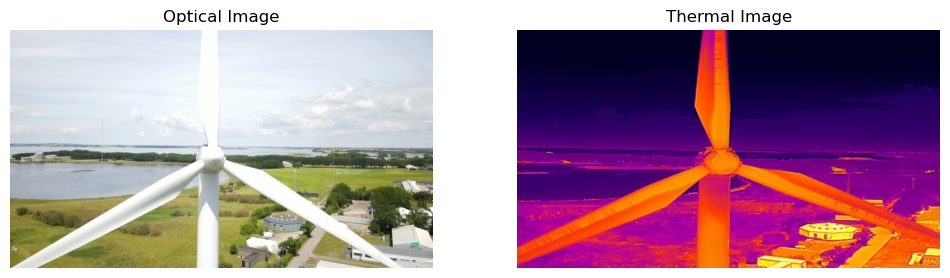

In [12]:
# ----------- STEP 7: Visualize first image pair -----------
import matplotlib.pyplot as plt

opt_img = Image.open(dataset.opt_imgs[0]).convert("RGB")
th_img = Image.open(dataset.th_imgs[0]).convert("RGB")

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.imshow(opt_img)
plt.title("Optical Image")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(th_img)
plt.title("Thermal Image")
plt.axis("off")

plt.show()


In [ ]:

# AQUADA-Seg: Image-based Optical-Thermal Blade Segmentation

import os
from pathlib import Path
from typing import Optional
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from PIL import Image
from tqdm import tqdm

# ----------- STEP 0: Dataset Paths -----------
DATA_ROOT = "./dataset_wind_blade"  # extracted dataset folder
SPLIT = "trainval"
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# ----------- STEP 1: Dataset Class -----------
class ImageDataset(Dataset):
    """
    Loads paired optical and thermal images
    """
    def __init__(self, root: str, split="trainval", transform=None):
        self.root = Path(root)
        self.split = split
        self.transform = transform
        self.opt_dir = self.root / "Images" / split / "Optical"
        self.th_dir = self.root / "Images" / split / "Thermal"

        # Recursively grab all images
        self.opt_imgs = sorted([p for p in self.opt_dir.rglob("*") if p.suffix.lower() in [".png",".jpg",".jpeg"]])
        self.th_imgs = sorted([p for p in self.th_dir.rglob("*") if p.suffix.lower() in [".png",".jpg",".jpeg"]])

        assert len(self.opt_imgs) == len(self.th_imgs), "Optical and thermal image counts mismatch!"

    def __len__(self):
        return len(self.opt_imgs)

    def __getitem__(self, idx):
        opt_img = Image.open(self.opt_imgs[idx]).convert("RGB")
        th_img = Image.open(self.th_imgs[idx]).convert("RGB")

        if self.transform:
            opt_img = self.transform(opt_img)
            th_img = self.transform(th_img)
        else:
            opt_img = transforms.ToTensor()(opt_img)
            th_img = transforms.ToTensor()(th_img)

        return opt_img, th_img

# ----------- STEP 2: Simple Dice Loss -----------
class DiceLoss(nn.Module):
    def __init__(self, eps=1e-6):
        super().__init__()
        self.eps = eps

    def forward(self, logits, targets):
        probs = torch.sigmoid(logits)
        targets = targets.float()
        num = 2 * (probs * targets).sum(dim=(1, 2, 3))
        den = (probs + targets).sum(dim=(1, 2, 3))
        dice = (num + self.eps) / (den + self.eps)
        return 1 - dice.mean()

# ----------- STEP 3: AQUADA-Seg Mini (Image-based) -----------

class Encoder(nn.Module):
    def __init__(self, backbone="resnet50"):
        super().__init__()
        resnet = models.resnet50(pretrained=True)
        self.feature_extractor = nn.Sequential(*list(resnet.children())[:-2])  # remove avgpool & fc
        self.key_conv = nn.Conv2d(2048, 256, kernel_size=1)
        self.project = nn.Conv2d(2048, 256, kernel_size=1)

    def forward(self, x):
        feat = self.feature_extractor(x)
        return self.project(feat), self.key_conv(feat)

class Decoder(nn.Module):
    def __init__(self):
        super().__init__()
        # Example decoder layers
        self.conv1 = nn.Conv2d(256, 128, 3, padding=1)
        self.conv2 = nn.Conv2d(128, 64, 3, padding=1)
        self.conv_out = nn.Conv2d(64, 1, 1)

    # Add optional target_size parameter
    def forward(self, x, target_size=None):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.conv_out(x)
        if target_size is not None:
            x = F.interpolate(x, size=target_size, mode='bilinear', align_corners=False)
        return x

class AQUADASeg(nn.Module):
    def __init__(self):
        super().__init__()
        self.enc_opt = Encoder()
        self.enc_th = Encoder()
        self.dec_opt = Decoder()
        self.dec_th = Decoder()

    def forward(self, opt_img, th_img):
        rep_o, key_o = self.enc_opt(opt_img)
        rep_t, key_t = self.enc_th(th_img)

        # upsample to original input size
        target_size = opt_img.shape[2:]  # (H, W)
        mask_o = self.dec_opt(rep_o, target_size=target_size)
        mask_t = self.dec_th(rep_t, target_size=target_size)

        return mask_o, mask_t

# ----------- STEP 4: Dataset & DataLoader -----------
transform = transforms.Compose([
    transforms.Resize((480, 853)),  # keep original resolution
    transforms.ToTensor()
])
dataset = ImageDataset(DATA_ROOT, SPLIT, transform=transform)
dataloader = DataLoader(dataset, batch_size=4, shuffle=True)

# ----------- STEP 5: Training Loop -----------
model = AQUADASeg().to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
dice_loss = DiceLoss()
bce_loss = nn.BCEWithLogitsLoss()

EPOCHS = 1  # for demo

for epoch in range(EPOCHS):
    total_loss = 0.0
    print(f"🚀 Epoch {epoch+1}/{EPOCHS}")
    for i, (opt_img, th_img) in enumerate(tqdm(dataloader, desc="Batches")):
        opt_img = opt_img.to(DEVICE)
        th_img = th_img.to(DEVICE)

        optimizer.zero_grad()
        mask_o, mask_t = model(opt_img, th_img)

        # Dummy target: for demo we can use the optical image itself as proxy
        target_o = (opt_img.mean(dim=1, keepdim=True) > 0.5).float()
        target_t = (th_img.mean(dim=1, keepdim=True) > 0.5).float()

        loss = bce_loss(mask_o, target_o) + bce_loss(mask_t, target_t) + \
               dice_loss(mask_o, target_o) + dice_loss(mask_t, target_t)

        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        if (i+1) % 50 == 0:
            print(f"Batch {i+1}/{len(dataloader)} | Loss: {total_loss/(i+1):.4f}")

    print(f"✅ Epoch {epoch+1} finished | Avg Loss: {total_loss/len(dataloader):.4f}")

print("🎉 Training finished!")


🚀 Epoch 1/1


Batches:   2%|▏         | 50/2179 [10:03<7:08:35, 12.08s/it]

Batch 50/2179 | Loss: 1.4971


Batches:   5%|▍         | 100/2179 [19:43<6:42:07, 11.61s/it]

Batch 100/2179 | Loss: 1.2070


Batches:   7%|▋         | 150/2179 [29:28<6:31:33, 11.58s/it]

Batch 150/2179 | Loss: 1.1211


Batches:   9%|▉         | 200/2179 [39:00<6:13:43, 11.33s/it]

Batch 200/2179 | Loss: 1.0360


Batches:  11%|█▏        | 250/2179 [56:53<29:03:43, 54.24s/it]

Batch 250/2179 | Loss: 0.9692


Batches:  12%|█▏        | 251/2179 [57:35<26:59:54, 50.41s/it]

In [13]:
print("hi")

hi


Optical image: dataset_wind_blade\Images\trainval\Optical\DJI_0101\00000.jpg
Thermal image: dataset_wind_blade\Images\trainval\Thermal\DJI_0101\00000.jpg


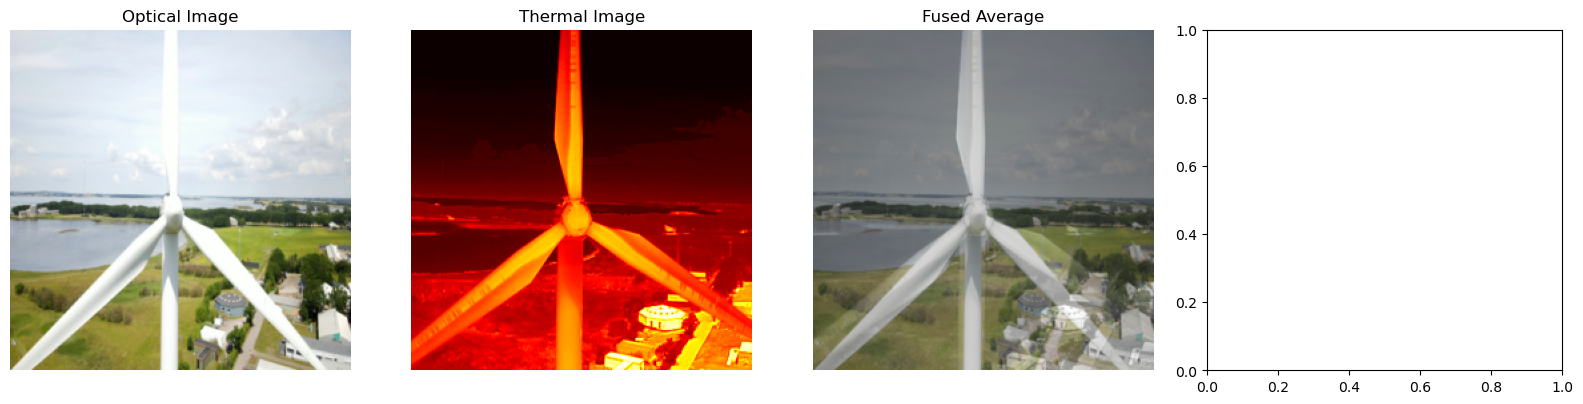

In [16]:

# Optical-Thermal Image Fusion Test

import os
from pathlib import Path
from PIL import Image
import torch
import torchvision.transforms as T
import matplotlib.pyplot as plt

# ----------- STEP 0: Paths -----------
DATA_ROOT = Path("./dataset_wind_blade/Images/trainval")
optical_path = DATA_ROOT / "Optical"
thermal_path = DATA_ROOT / "Thermal"

# ----------- STEP 1: Get all image files recursively -----------
opt_files = sorted([p for p in optical_path.rglob("*") if p.suffix.lower() in [".png", ".jpg", ".jpeg"]])
th_files = sorted([p for p in thermal_path.rglob("*") if p.suffix.lower() in [".png", ".jpg", ".jpeg"]])

# Pick first image from each
opt_img_path = opt_files[0]
th_img_path = th_files[0]

print("Optical image:", opt_img_path)
print("Thermal image:", th_img_path)

# ----------- STEP 2: Load Images -----------
opt_img = Image.open(opt_img_path).convert("RGB")
th_img = Image.open(th_img_path).convert("L")  # thermal grayscale

# ----------- STEP 3: Transforms -----------
transform = T.Compose([
    T.Resize((256, 256)),
    T.ToTensor(),
])

opt_tensor = transform(opt_img)
th_tensor = transform(th_img)

# Normalize to [0,1]
opt_tensor = (opt_tensor - opt_tensor.min()) / (opt_tensor.max() - opt_tensor.min())
th_tensor = (th_tensor - th_tensor.min()) / (th_tensor.max() - th_tensor.min())

# ----------- STEP 4: Fusion -----------
# Method 1: Simple average fusion
# Expand thermal to 3 channels to match RGB
th_tensor_3ch = th_tensor.expand_as(opt_tensor)
fused_tensor = (opt_tensor + th_tensor_3ch) / 2

# Optional overlay (blend thermal into red channel)
overlay_tensor = opt_tensor.clone()
overlay_tensor[0] = (opt_tensor[0] * 0.5 + th_tensor * 0.5)  # only red channel blended

# ----------- STEP 5: Visualization -----------
fig, ax = plt.subplots(1, 4, figsize=(16, 4))

ax[0].imshow(opt_tensor.permute(1, 2, 0))
ax[0].set_title("Optical Image")
ax[0].axis("off")

ax[1].imshow(th_tensor.squeeze(), cmap='hot')
ax[1].set_title("Thermal Image")
ax[1].axis("off")

ax[2].imshow(fused_tensor.permute(1, 2, 0))
ax[2].set_title("Fused Average")
ax[2].axis("off")

plt.tight_layout()
plt.show()
